# Downloading images from LAION-5B

LAION-5B is a dataset with 5 billion image/text pairs.

It has been indexed using CLIP and can be queried using text/images.

Goal:
* Download 100 images for each of the classes in FoodVision.
* See how good these images are to use as a dataset for future models.
* Increase the number of images downloaded if they are good quality.

Resources:
* See the code on GitHub: https://github.com/rom1504/clip-retrieval 
* See the blog post: https://laion.ai/blog/h14_clip_retrieval/ 
* See the demo: https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn.laion.ai&index=laion5B-H-14&useMclip=false&query=salt+shaker+photo 
* Example notebook: https://github.com/rom1504/clip-retrieval/blob/main/notebook/clip-client-query-api.ipynb 

## Try downloading images for a single class

In [134]:
from clip_retrieval.clip_client import ClipClient, Modality

client = ClipClient(url="https://knn.laion.ai/knn-service", 
                    indice_name="laion5B-H-14", # H = Huge, L = Large (huge is bigger than large)
                    num_images=100)

In [135]:
results = client.query(text="salt shaker photo")
results[0]

{'caption': 'Salt_shaker_on_white_background',
 'url': 'https://diabetesdietblogdotcom.files.wordpress.com/2016/03/salt_shaker_on_white_background.jpg?w=610',
 'id': 3637752355,
 'similarity': 0.40506356954574585}

In [14]:
# Save results to JSON file
import json
with open("clip_retrieval_results.json", "w") as f:
    json.dump(results, f)

## Download images

Going to download the resulting images with `img2dataset`, see the GitHub here: https://github.com/rom1504/img2dataset

In [16]:
!img2dataset "clip_retrieval_results.json" --input_format="json" --caption_col "caption" --output_folder="clip_retrieval_results" --resize_mode="no" --output_format="files"

Starting the downloading of this file
Sharding file number 1 of 1 called /home/daniel/code/nutrify/foodvision/notebooks/clip_retrieval_results.json
0it [00:00, ?it/s]File sharded in 1 shards
1it [00:09,  9.72s/it]
worker  - success: 0.881 - failed to download: 0.119 - failed to resize: 0.000 - images per sec: 5 - count: 42
total   - success: 0.881 - failed to download: 0.119 - failed to resize: 0.000 - images per sec: 5 - count: 42


In [15]:
# !rm -rf clip_retrieval_results/*

In [5]:
# List how many images are in clip_retrieval_results folder
!ls -l clip_retrieval_results | wc -l

4


## Get class names from labels

In [136]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

In [137]:
# Get config
from configs.default_config import config

args = config
print(args)

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['internet_image_download'],
                 notes="download ~100x images per class using clip-retrieval")

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

namespace(annotations_columns_to_export=['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source'], auto_augment=True, batch_size=128, epochs=10, gs_bucket_name='food_vision_bucket_with_object_versioning', gs_image_storage_path='https://storage.cloud.google.com/food_vision_bucket_with_object_versioning/all_images/', input_size=224, label_smoothing=0.1, learning_rate=0.001, model='coatnext_nano_rw_224', num_to_try_and_autocorrect=1000, path_to_gcp_credentials='utils/google-storage-key.json', path_to_label_studio_api_key='utils/label_studio_api_key.json', pretrained=True, seed=42, use_mixed_precision=True, wandb_dataset_artifact='food_vision_199_classes_images:latest', wandb_job_type='', wandb_labels_artifact='food_vision_labels:latest', wandb_model_artifact='trained_model:latest', wandb_project='test_wandb_artifacts_by_reference', wandb_run_notes='', wandb_run_tag

[INFO] Labels directory: ./artifacts/food_vision_labels:v25
[INFO] Labels path: artifacts/food_vision_labels:v25/annotations.csv
[INFO] Working with: 208 classes


In [138]:
class_names[:10]

['almond_butter',
 'almonds',
 'apple_green',
 'apple_red',
 'apricot',
 'asparagus',
 'avocado',
 'bacon',
 'bacon_and_egg_burger',
 'bagel']

### Loop through class names and download X images per class

In [139]:
from clip_retrieval.clip_client import ClipClient

num_images_to_get = 3000

client = ClipClient(url="https://knn.laion.ai/knn-service", 
                    indice_name="laion5B-H-14", # H = Huge, L = Large (huge is bigger than large)
                    num_images=num_images_to_get)

In [140]:
len(reverse_class_dict)

208

In [141]:
# Get list of class_names from annotations with less than min_threshold # of images
min_threshold = 1000
class_names_to_download = []
for class_name in class_names:
    if len(annotations[annotations["class_name"] == class_name]) < min_threshold:
        class_names_to_download.append(class_name)
class_names_to_download

['apple_green',
 'bread_naan',
 'curry_chicken',
 'fruit_smoothie',
 'grapes_black',
 'grapes_white',
 'prosciutto']

In [ ]:
# Create this as a list to add more classes to download
extra_class_names_to_download = ['artichoke',
  'bay_leaves',
  'bean_sprouts',
  'cabbage_green',
  'capsicum_green',
  'capsicum_orange',
  'capsicum_red',
  'capsicum_yellow',
  'chervil',
  'chicory',
  'choy_sum',
  'curry_leaves',
  'dill',
  'jalapeno',
  'lemongrass',
  'lime_leaves',
  'marjoram',
  'oregano',
  'peanuts',
  'quince',
  'sage',
  'silverbeet',
  'swede',
  'tarragon',
  'thyme',
  'turmeric',
  'witlof',
  'wombok',
  'beef_patty'] 

class_names_to_download_plus_extras = class_names_to_download + extra_class_names_to_download


In [142]:
from tqdm.auto import tqdm

combined_results = []
for class_name in tqdm(class_names_to_download):
    results = client.query(text=f"{class_name} photo")
    for result in results:
    # print(results)
        result["class_name"] = class_name
        try:
            result["label"] = reverse_class_dict[class_name] 
        except KeyError:
            result["label"] = None # if no label is present, set to None, can update this later

    combined_results.extend(results)

len(combined_results)

  0%|          | 0/7 [00:00<?, ?it/s]

476

In [ ]:
# Put a check here to see if any of the images are already downloaded
# If they are, remove them from the combined_results list

# Download file from GCP of all images already downloaded
# Go through the file of downloaded images
# If the image is in the combined_results list, remove it from the list

check_for_images_already_downloaded = True

if check_for_images_already_downloaded:
    # Download file from GCP of all images already downloaded
    from utils.gcp_utils import download_file_from_gcp_bucket
    from utils.file_utils import load_json_file

    # Download file from GCP of all images already downloaded
    download_file_from_gcp_bucket(bucket_name=args.gcp_bucket_name, 
                                  source_blob_name=args.gcp_blob_name, 
                                  destination_file_name=args.gcp_blob_name)

    # Load file
    downloaded_images = load_json_file(args.gcp_blob_name)

    # Go through the file of downloaded images
    # If the image is in the combined_results list, remove it from the list
    for image in downloaded_images:
        for result in combined_results:
            if image["url"] == result["url"]:
                combined_results.remove(result)


In [143]:
# Select a random result
import random
random.choice(combined_results)
# combined_results[0]

{'caption': 'Top view of rotating acorn ham slices, closeup view',
 'url': 'https://ak.picdn.net/shutterstock/videos/21772000/thumb/1.jpg',
 'id': 1853409630,
 'similarity': 0.3646734356880188,
 'class_name': 'prosciutto',
 'label': 208}

In [144]:
# Save results to JSON
import json

# Get current timestamp
from utils.misc import get_now_time
now = get_now_time()

save_path = f"{now}_clip_retrieval_{num_images_to_get}_images_per_class.json"

with open(save_path, "w") as f:
    json.dump(combined_results, f)


In [146]:
# Download results to local machine
# Path 2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json
!img2dataset $save_path --input_format="json" --caption_col "caption" --output_folder="2023_02_15_clip_retrieval_100_images_per_class" --resize_mode="no" --output_format="files"

Starting the downloading of this file
Sharding file number 1 of 1 called /home/daniel/code/nutrify/foodvision/notebooks/2023-02-15_14-22-52_clip_retrieval_100_images_per_class.json
0it [00:00, ?it/s]File sharded in 1 shards
1it [00:14, 14.75s/it]
worker  - success: 0.901 - failed to download: 0.080 - failed to resize: 0.019 - images per sec: 37 - count: 476
total   - success: 0.901 - failed to download: 0.080 - failed to resize: 0.019 - images per sec: 37 - count: 476


In [ ]:
# After running the above command, save the file to GCP
# !gsutil cp -r 2023_02_15_clip_retrieval_100_images_per_class gs://laion-ai-ml-datasets/food101/clip_retrieval_results

# Upload file to GCP
from utils.gcp_utils import upload_file_to_gcp_bucket

# Upload file to GCP to save for later
upload_file_to_gcp_bucket(bucket_name=args.gcp_bucket_name,
                          source_file_name=save_path,
                          destination_blob_name=save_path)

In [ ]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_DOWNLOADED_FROM_LAION_5B_TARGET_FILENAME = "updated_images_downloaded_from_laion_5b.json"
ORIGINAL_DOWNLOADED_FROM_LAION_5B_FILENAME = "images_downloaded_from_laion_5b.json"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

In [ ]:
# Next:
# Go through downloaded images and label them with their appropriate class (they can be matched via their URL)
# Add a UUID to each image 
# Create labels for images in same style as FoodVision labels
# Make an image source tag for where the images came from
# Upload to GCP as all training images (can swap 20% to test set later)
# Track updated labels and images in Weights & Biases
# Train a model with and without new images (on unmodified test set)

In [147]:
# Read in the file and explore it
import json

with open(save_path, "r") as f:
    results = json.load(f)

results[0]

{'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】 お届け...',
 'url': 'http://thumbnail.image.rakuten.co.jp/@0_mall/f202011-nagano/cabinet/55660321_01_web.jpg?_ex=128x128',
 'id': 3498151969,
 'similarity': 0.40787839889526367,
 'class_name': 'apple_green',
 'label': 199}

In [148]:
len(results)

476

In [151]:
# Get today's date in YYYY_MM_DD format
from datetime import date
today = date.today()
today = today.strftime("%Y_%m_%d")
print(today)

target_dir = f"{today}_clip_retrieval_100_images_per_class"

# Get a list of all .JSON files in target_dir
import glob
json_files = glob.glob(f"{target_dir}/*/*.json")
len(json_files)

2023_02_15


429

In [152]:
# Open each .JSON file and append it to a list
import json
all_json = []
for json_file in json_files:
    with open(json_file, "r") as f:
        json_data = json.load(f)
        all_json.append(json_data)
len(all_json)

429

In [154]:
all_json[0]

{'caption': 'tasty italian focaccia with salt and olive oil',
 'url': 'https://us.123rf.com/450wm/michelepautasso/michelepautasso1306/michelepautasso130600030/20201701-tasty-italian-focaccia-with-salt-and-olive-oil.jpg?ver=6',
 'key': '000000131',
 'status': 'success',
 'error_message': None,
 'width': 450,
 'height': 299,
 'original_width': 450,
 'original_height': 299,
 'exif': '{}',
 'sha256': '9a0b4099bddb6ede51eb5ed7c4784410f39101ac9501787cfbf925421fcd144c'}

In [155]:
# Loop through all_json and match the URL to the URL in the results list
for result in results:
    for json_data in all_json:
        if result["url"] == json_data["url"]:
            result["json_data"] = json_data
            break

In [156]:
results[0]

{'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】 お届け...',
 'url': 'http://thumbnail.image.rakuten.co.jp/@0_mall/f202011-nagano/cabinet/55660321_01_web.jpg?_ex=128x128',
 'id': 3498151969,
 'similarity': 0.40787839889526367,
 'class_name': 'apple_green',
 'label': 199,
 'json_data': {'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】 お届け...',
  'url': 'http://thumbnail.image.rakuten.co.jp/@0_mall/f202011-nagano/cabinet/55660321_01_web.jpg?_ex=128x128',
  'key': '000000000',
  'status': 'success',
  'error_message': None,
  'width': 128,
  'height': 79,
  'original_width': 128,
  'original_height': 79,
  'exif': '{}',
  'sha256': 'a060df877ae8314f90d9ad8461e7260dd5c1357aac6b88f89b44e5ba223473b1'}}

In [157]:
# Get all the image paths
import glob
image_files = glob.glob(f"{target_dir}/*/*.jpg")
image_files[:10], len(image_files)

(['2023_02_15_clip_retrieval_100_images_per_class/00000/000000281.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000115.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000215.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000220.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000249.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000113.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000273.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000360.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000160.jpg',
  '2023_02_15_clip_retrieval_100_images_per_class/00000/000000073.jpg'],
 429)

In [158]:
# Got through the results and if the json_data key exists, add the image path to the result
for result in results:
    if "json_data" in result:
        for image_file in image_files:
            if result["json_data"]["key"] == image_file.split("/")[-1].split(".")[0]:
                result["image_path"] = image_file
                break

In [159]:
results[:3]

[{'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】 お届け...',
  'url': 'http://thumbnail.image.rakuten.co.jp/@0_mall/f202011-nagano/cabinet/55660321_01_web.jpg?_ex=128x128',
  'id': 3498151969,
  'similarity': 0.40787839889526367,
  'class_name': 'apple_green',
  'label': 199,
  'json_data': {'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】 お届け...',
   'url': 'http://thumbnail.image.rakuten.co.jp/@0_mall/f202011-nagano/cabinet/55660321_01_web.jpg?_ex=128x128',
   'key': '000000000',
   'status': 'success',
   'error_message': None,
   'width': 128,
   'height': 79,
   'original_width': 128,
   'original_height': 79,
   'exif': '{}',
   'sha256': 'a060df877ae8314f90d9ad8461e7260dd5c1357aac6b88f89b44e5ba223473b1'},
  'image_path': '2023_02_15_clip_retrieval_100_images_per_class/00000/000000000.jpg'},
 {'caption': 'Apple fruit Wallpaper',
  'url': 'https://hdwallsbox.com/wallpapers/s/86/apple-fruit-s85280.jpg',
  'id': 1468762284,
  'similarity': 0.40312281250953674,
  '

In [160]:
# Create a subset of results where image_path is not None
# TODO: these are the images that have been downloaded, so use this to check how many images were downloaded
# then can save this subset as "images already downloaded" to prevent doubling up...
results_with_image_path = [result for result in results if "image_path" in result]
len(results_with_image_path)

429

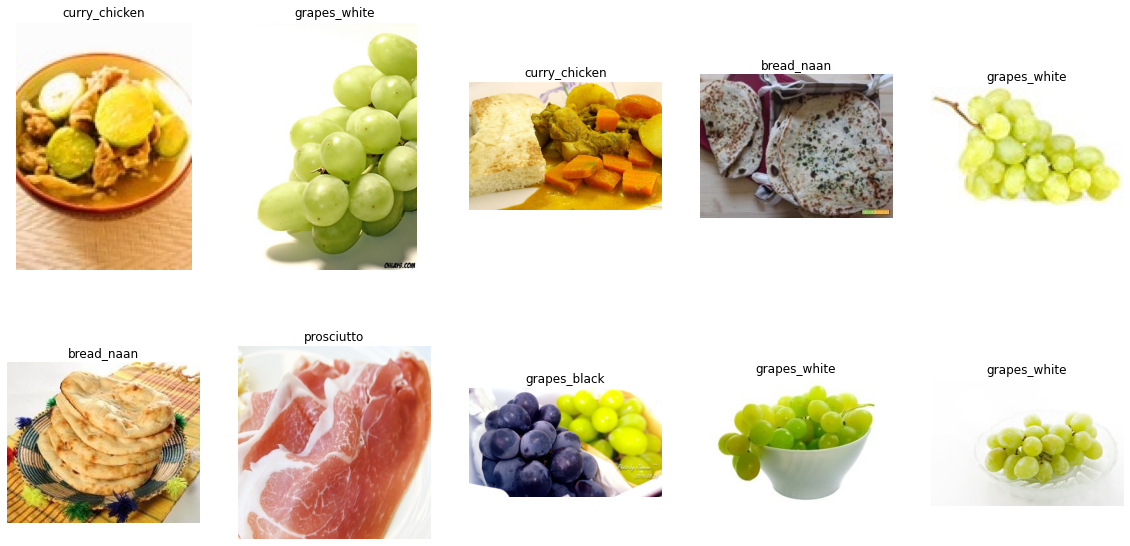

In [161]:
# Plot 10 random images from results with the class_name as the title
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    result = random.choice(results_with_image_path)
    ax.imshow(plt.imread(result["image_path"]))
    ax.set_title(result["class_name"])
    ax.axis("off")

In [162]:
# Turn results into a dataframe
import pandas as pd
df = pd.DataFrame(results_with_image_path)
df.head()

,caption,url,id,similarity,class_name,label,json_data,image_path
0,【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4.5キロ 【果物・フルーツ】...,http://thumbnail.image.rakuten.co.jp/@0_mall/f...,3498151969,0.407878,apple_green,199,{'caption': '【ふるさと納税】【2019年度産】長野市産 グラニースミス 約4....,2023_02_15_clip_retrieval_100_images_per_class...
1,Apple fruit Wallpaper,https://hdwallsbox.com/wallpapers/s/86/apple-f...,1468762284,0.403123,apple_green,199,"{'caption': 'Apple fruit Wallpaper', 'url': 'h...",2023_02_15_clip_retrieval_100_images_per_class...
2,Green apples on emerald gingham Royalty Free S...,https://thumbs.dreamstime.com/m/green-apples-e...,476002161,0.401480,apple_green,199,{'caption': 'Green apples on emerald gingham R...,2023_02_15_clip_retrieval_100_images_per_class...
3,manzanas y flores,https://static.vecteezy.com/system/resources/t...,3914780349,0.393083,apple_green,199,"{'caption': 'manzanas y flores', 'url': 'https...",2023_02_15_clip_retrieval_100_images_per_class...
4,Un type de pomme surpuissant pour la santé,https://3.bp.blogspot.com/-y1imz1Sr-CM/WH-kiUv...,2823226500,0.392202,apple_green,199,{'caption': 'Un type de pomme surpuissant pour...,2023_02_15_clip_retrieval_100_images_per_class...


In [163]:
# Find the unqiue class_names in the dataframe
unique_class_names = list(df["class_name"].unique())
len(unique_class_names)

[]

In [164]:
# Missing classes
list(set(class_names) - set(unique_class_names))

['ginger',
 'onion_green',
 'pork_chop',
 'watermelon',
 'yoghurt',
 'goji_berries',
 'pear',
 'hot_chocolate',
 'gyoza',
 'asparagus',
 'roast_beef',
 'beef_mince',
 'pasta',
 'passionfruit',
 'apricot',
 'lettuce',
 'zucchini',
 'celery',
 'chocolate_cake',
 'potato_scallop',
 'candy',
 'peach',
 'soda',
 'strawberries',
 'mandarin',
 'tomato_chutney',
 'carrot',
 'cream',
 'corn_chips',
 'parsnips',
 'sports_drink',
 'salt',
 'oysters',
 'dates',
 'grapes_red',
 'olive_oil',
 'jerusalem_artichoke',
 'raspberries',
 'starfruit',
 'garlic',
 'croissant',
 'ice_cream',
 'daikon_radish',
 'rosemary',
 'almond_butter',
 'pain_au_chocolat',
 'chicken_wings',
 'orange_juice',
 'salad',
 'onion_brown',
 'capsicum',
 'pawpaw',
 'pork_belly',
 'bok_choy',
 'tomato',
 'biltong',
 'mayonnaise',
 'pineapple',
 'ham',
 'milk',
 'scrambled_eggs',
 'maple_syrup',
 'cucumber',
 'toast',
 'french_toast',
 'parsley',
 'beef_curry',
 'sweet_potato',
 'kimchi',
 'rhubarb',
 'turnip',
 'figs',
 'radish',

In [165]:
# Turn the DataFrame into a list of dictionaries
results_list = df.to_dict("records")
len(results_list)

429

In [167]:
class_names_to_download

['apple_green',
 'bread_naan',
 'curry_chicken',
 'fruit_smoothie',
 'grapes_black',
 'grapes_white',
 'prosciutto']

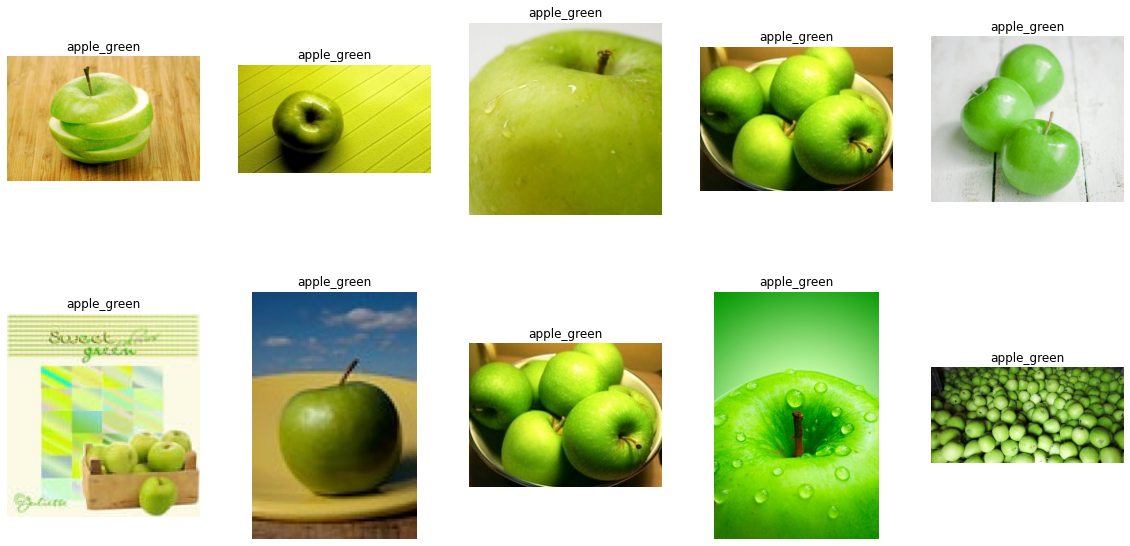

In [169]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
filter = "green"
results_list_filter = [result for result in results_list if filter in result["class_name"]]

for i, ax in enumerate(axes.flatten()):    
    result = random.choice(results_list_filter)
    ax.imshow(plt.imread(result["image_path"]))
    ax.set_title(result["class_name"])
    ax.axis("off")

In [170]:
# Get the average size of each image
from PIL import Image
from tqdm.auto import tqdm

image_sizes = []
for result in tqdm(results_list):
    image = Image.open(result["image_path"])
    image_sizes.append(image.size)


  0%|          | 0/429 [00:00<?, ?it/s]

In [171]:
# Flatten image_sizes into a single list
image_sizes = [size for image_size in image_sizes for size in image_size]
image_sizes[:10]

[128, 79, 338, 190, 87, 130, 300, 200, 200, 155]

In [172]:
# Get the statistics about each image
import numpy as np

mean_image_size = np.mean(image_sizes)
median_image_size = np.median(image_sizes)
max_image_size = np.max(image_sizes)
min_image_size = np.min(image_sizes)

print(f"Mean image size: {mean_image_size}")
print(f"Median image size: {median_image_size}")
print(f"Max image size: {max_image_size}")
print(f"Min image size: {min_image_size}")


Mean image size: 338.02797202797206
Median image size: 240.0
Max image size: 5280
Min image size: 66


In [173]:
# Find the average file size for each image
import os

for result in results_list:
    result["file_size_mb"] = os.path.getsize(result["image_path"]) / 1e6

In [174]:
# Get the statistics about each image
import numpy as np

mean_file_size = np.mean([result["file_size_mb"] for result in results_list])
median_file_size = np.median([result["file_size_mb"] for result in results_list])
max_file_size = np.max([result["file_size_mb"] for result in results_list])
min_file_size = np.min([result["file_size_mb"] for result in results_list])

print(f"Mean file size: {mean_file_size}")
print(f"Median file size: {median_file_size}")
print(f"Max file size: {max_file_size}")
print(f"Min file size: {min_file_size}")

Mean file size: 0.047187072261072265
Median file size: 0.020023
Max file size: 2.99207
Min file size: 0.002542


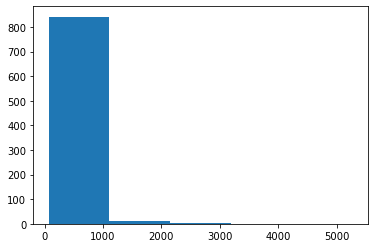

In [175]:
# Plot a histogram of image sizes
plt.hist(image_sizes, bins=5);

## Create labels for images downloaded from LAION-5B

In [176]:
class_names_all = []
for result in results_list:
    class_names_all.append(result["class_name"])
sorted(list(set(class_names_all)))

['apple_green',
 'bread_naan',
 'curry_chicken',
 'fruit_smoothie',
 'grapes_black',
 'grapes_white',
 'prosciutto']

In [177]:
from utils.misc import get_now_time

# Create a list of dictionaries and fill out the columns of the annotations
columns = ['filename',
 'image_name',
 'class_name',
 'label',
 'split',
 'clear_or_confusing',
 'whole_food_or_dish',
 'one_food_or_multiple',
 'label_last_updated_at',
 'label_source',
 'image_source']

IMAGE_SOURCE = 'clip_retrieval_laion_5b_knn'
LABEL_SOURCE = 'clip_retrieval_laion_5b_knn'
LABEL_LAST_UPDATED_AT = get_now_time()

food_image_dict_list = []
for result in tqdm(results_list):
    food_image_dict = {}
    food_image_dict['filename'] = result["image_path"]
    food_image_dict['image_name'] = result["image_path"].split("/")[-1]
    food_image_dict['class_name'] = result["class_name"]
    try:
        food_image_dict['label'] = reverse_class_dict[result["class_name"]]
    except:
        food_image_dict['label'] = None
    # food_image_dict['split'] = 'train'
    # Label 20% of the images as test
    if np.random.random() < 0.2:
        food_image_dict['split'] = 'test'
    else:
        food_image_dict['split'] = 'train'
    food_image_dict['clear_or_confusing'] = None
    food_image_dict['whole_food_or_dish'] = None
    food_image_dict['one_food_or_multiple'] = None
    food_image_dict['label_last_updated_at'] = LABEL_LAST_UPDATED_AT
    food_image_dict['label_source'] = LABEL_SOURCE
    food_image_dict['image_source'] = IMAGE_SOURCE

    food_image_dict_list.append(food_image_dict)

# Create a dataframe from the list of dictionaries
import pandas as pd
new_annotations = pd.DataFrame(food_image_dict_list)
new_annotations.head()

  0%|          | 0/429 [00:00<?, ?it/s]

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,2023_02_15_clip_retrieval_100_images_per_class...,000000000.jpg,apple_green,199,test,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
1,2023_02_15_clip_retrieval_100_images_per_class...,000000001.jpg,apple_green,199,test,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
2,2023_02_15_clip_retrieval_100_images_per_class...,000000002.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
3,2023_02_15_clip_retrieval_100_images_per_class...,000000003.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
4,2023_02_15_clip_retrieval_100_images_per_class...,000000004.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn


In [178]:
# Give each image name a unique UUID (to avoid duplicates)
import uuid

def is_valid_uuid(string):
    try:
        uuid.UUID(string)
        return True
    except ValueError:
        return False

new_annotations["image_name"] = new_annotations["image_name"].apply(lambda x: str(uuid.uuid4()) + ".jpg" if not is_valid_uuid(x.split(".")[0]) else x)
new_annotations.head()

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,2023_02_15_clip_retrieval_100_images_per_class...,41dbdee2-ce1b-48f2-bdc3-07d173277ca2.jpg,apple_green,199,test,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
1,2023_02_15_clip_retrieval_100_images_per_class...,dcff5c31-88a3-4adf-a3be-7eef8f008ec0.jpg,apple_green,199,test,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
2,2023_02_15_clip_retrieval_100_images_per_class...,95115db2-ea0e-44f1-9d23-7dbc98d61bc2.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
3,2023_02_15_clip_retrieval_100_images_per_class...,ce20cb90-0ef6-40fe-a940-0d578f6c2d8d.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
4,2023_02_15_clip_retrieval_100_images_per_class...,81ddd178-ed6d-41c5-8cba-037299b1b8de.jpg,apple_green,199,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn


In [179]:
# How many images are in each split?
new_annotations["split"].value_counts()

train    352
test      77
Name: split, dtype: int64

In [120]:
# Next: 
# Create labels for all the images in the same style as FoodVision labels ✅
# Refine the script above to see if it works... (repeatably with more images)
# Make an image source tag for where the images came from (e.g. "clip_retrieval") ✅
# Upload to GCP as all training images (can swap 20% to test set later) ✅
# Track updated labels and images in Weights & Biases
# Train a model with and without new images + with new images and see what happens

In [180]:
original_annotations = annotations.copy()
len(original_annotations)

40267

In [181]:
# Append the new_annotations to the original_annotations
updated_annotations = pd.concat([original_annotations, new_annotations], ignore_index=True)
# updated_annotations = original_annotations.(new_annotations, ignore_index=True)
updated_annotations

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...,4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg,pain_au_chocolat,121,test,NaN,NaN,NaN,NaN,NaN,internet_download
1,test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...,2062f52a-781c-4e4f-b8a7-0a108934f453.jpg,pain_au_chocolat,121,test,NaN,NaN,NaN,NaN,NaN,internet_download
2,test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...,8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg,pain_au_chocolat,121,test,NaN,NaN,NaN,NaN,NaN,internet_download
3,test/pain_au_chocolat/839437c8-c643-408f-9f04-...,839437c8-c643-408f-9f04-d0d3bec238c3.jpg,pain_au_chocolat,121,test,NaN,NaN,NaN,NaN,NaN,internet_download
4,test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...,ca5c13ff-a535-4b69-9144-e06275e01e35.jpg,pain_au_chocolat,121,test,NaN,NaN,NaN,NaN,NaN,internet_download
...,...,...,...,...,...,...,...,...,...,...,...
40691,2023_02_15_clip_retrieval_100_images_per_class...,8956c219-2486-40f5-976e-10cf94940c2a.jpg,prosciutto,208,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
40692,2023_02_15_clip_retrieval_100_images_per_class...,0c9095b6-0d6a-4e0c-a75d-64e043d0bf71.jpg,prosciutto,208,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
40693,2023_02_15_clip_retrieval_100_images_per_class...,96e3afe6-2334-430f-b655-c19fc9df0685.jpg,prosciutto,208,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn
40694,2023_02_15_clip_retrieval_100_images_per_class...,4a64a7eb-007e-46f3-903b-9a228d5ca422.jpg,prosciutto,208,train,None,None,None,2023-02-15_14-28-33,clip_retrieval_laion_5b_knn,clip_retrieval_laion_5b_knn


In [182]:
from typing import List, Dict, Tuple

def get_updated_class_names_class_dict_and_reverse_class_dict(df: pd.DataFrame) -> Tuple[List[str], Dict[int, str], Dict[str, int]]:
    """Get an updated class names list, class dict and reverse class dict from a dataframe."""
    updated_class_names = sorted(df.class_name.unique())
    updated_class_dict = {i: class_name for i, class_name in enumerate(updated_class_names)}
    updated_reverse_class_dict = {class_name: i for i, class_name in enumerate(updated_class_names)}
    assert len(updated_class_dict) == len(updated_reverse_class_dict), "Class dict and reverse class dict are not the same length"
    return updated_class_names, updated_class_dict, updated_reverse_class_dict

def map_updated_class_dict_to_updated_annotations(df: pd.DataFrame, updated_reverse_class_dict: Dict[str, int]) -> pd.DataFrame:
    """Map updated class dict to updated annotations dataframe.
    
    For example, go from {"apple_red": 1} -> df["label"] = 1
    """
    updated_annotations = df.copy()
    updated_annotations.loc[:, 'label'] = updated_annotations['class_name'].map(updated_reverse_class_dict)
    assert len(updated_annotations.label.unique()) == len(updated_reverse_class_dict), "Number of unique labels in updated annotations does not match number of unique class names in updated reverse class dict"
    return updated_annotations

# Check for different class names
if len(updated_annotations['class_name'].unique()) == len(original_annotations['class_name'].unique()):
    print("No new classes added, no need to remap labels...")
else:
    # Remap the labels
    print("New classes added, remapping labels...")
    updated_class_names, updated_class_dict, updated_reverse_class_dict = get_updated_class_names_class_dict_and_reverse_class_dict(updated_annotations)
    updated_annotations = map_updated_class_dict_to_updated_annotations(updated_annotations, updated_reverse_class_dict)

# How many unique class_names are in original_annotations?
print(f"Number of unique classes in updated_annotations: {len(updated_annotations['class_name'].unique())}")

# How many unique class_names are in original_annotations?
print(f"Number of unique classes in original_annotations: {len(original_annotations['class_name'].unique())}")

# How many new classes got added?
print(f"Number of new classes added: {len(updated_class_names) - len(original_annotations['class_name'].unique())}")

208
208


In [183]:
# Check the difference in lengths between the original_annotations and updated_annotations
from utils.misc import check_for_differences_between_df

num_differences = check_for_differences_between_df(updated_annotations, original_annotations)
num_differences

429

In [184]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 429 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 6790526 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-02-15_14-29-08_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


## Upload images to GCP bucket

In [185]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 39389 images in the GCP bucket


In [186]:
gs_image_paths_name = [str(blob.name).split("/")[-1] for blob in gs_image_paths]
gs_image_paths_name[:10]

['00045a69-b09f-4293-8c2e-a7ba27964fb6.jpg',
 '0009bea1-1577-4db5-bc60-b27eaed2d276.jpg',
 '000bd61c-f25c-415c-8cf1-3adc2d788320.jpg',
 '000cb663-06ac-4f96-8f9b-795cd05b5bcf.jpg',
 '000ec632-ee17-4988-9b32-8e4cb1421636.jpg',
 '0010ae4e-0879-4447-9610-e9d422caadd7.jpg',
 '0012b344-1bf9-421b-977e-d4ad8a6dcb7b.jpg',
 '00141b2a-0ed8-45b0-8823-8c0dbef3ac93.jpg',
 '0014f5f6-c37f-4922-8524-efc118f7d17b.jpg',
 '0018f7dd-217b-478b-9858-289922cf9715.jpg']

In [187]:
# Turn the DataFrame into a list of dictionaries
food_image_dict_list = new_annotations.to_dict(orient="records")
food_image_dict_list[:2]

[{'filename': '2023_02_15_clip_retrieval_100_images_per_class/00000/000000000.jpg',
  'image_name': '41dbdee2-ce1b-48f2-bdc3-07d173277ca2.jpg',
  'class_name': 'apple_green',
  'label': 199,
  'split': 'test',
  'clear_or_confusing': None,
  'whole_food_or_dish': None,
  'one_food_or_multiple': None,
  'label_last_updated_at': '2023-02-15_14-28-33',
  'label_source': 'clip_retrieval_laion_5b_knn',
  'image_source': 'clip_retrieval_laion_5b_knn'},
 {'filename': '2023_02_15_clip_retrieval_100_images_per_class/00000/000000001.jpg',
  'image_name': 'dcff5c31-88a3-4adf-a3be-7eef8f008ec0.jpg',
  'class_name': 'apple_green',
  'label': 199,
  'split': 'test',
  'clear_or_confusing': None,
  'whole_food_or_dish': None,
  'one_food_or_multiple': None,
  'label_last_updated_at': '2023-02-15_14-28-33',
  'label_source': 'clip_retrieval_laion_5b_knn',
  'image_source': 'clip_retrieval_laion_5b_knn'}]

In [ ]:
# TODO: Use gsutil to upload the images to GCP

In [188]:
# Loop through image_paths and upload the image as long as its name isn't in gs_image_paths_name
from tqdm.auto import tqdm

num_images_uploaded = 0
for food_image_dict in tqdm(food_image_dict_list):
    image_path = Path(food_image_dict["filename"])
    image_name = food_image_dict["image_name"]
    if image_name not in gs_image_paths_name:
        
        print(f"Uploading {image_path} to GCP bucket as '{image_name}'")

        # Upload the image to Google Storage
        upload_to_gs(bucket_name=GS_BUCKET_NAME,
                     source_file_name=image_path,
                     destination_blob_name=f"all_images/{image_name}")
        
        num_images_uploaded += 1

print(f"[INFO] Uploaded {num_images_uploaded} images to GCP bucket")

  0%|          | 0/429 [00:00<?, ?it/s]

Uploading 2023_02_15_clip_retrieval_100_images_per_class/00000/000000000.jpg to GCP bucket as '41dbdee2-ce1b-48f2-bdc3-07d173277ca2.jpg'
[INFO] Uploading 2023_02_15_clip_retrieval_100_images_per_class/00000/000000000.jpg to all_images/41dbdee2-ce1b-48f2-bdc3-07d173277ca2.jpg...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File 2023_02_15_clip_retrieval_100_images_per_class/00000/000000000.jpg uploaded to food_vision_bucket_with_object_versioning/all_images/41dbdee2-ce1b-48f2-bdc3-07d173277ca2.jpg.
[INFO] File size: 7156 bytes
Uploading 2023_02_15_clip_retrieval_100_images_per_class/00000/000000001.jpg to GCP bucket as 'dcff5c31-88a3-4adf-a3be-7eef8f008ec0.jpg'
[INFO] Uploading 2023_02_15_clip_retrieval_100_images_per_class/00000/000000001.jpg to all_images/dcff5c31-88a3-4adf-a3be-7eef8f008ec0.jpg...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File 2023_02_15_clip_retrieval_100_images_per_clas

In [189]:
# Track the changes to GCP bucket with Weights & Biases
from utils.wandb_utils import wandb_add_artifact_with_reference

# Track updated images_dir in Weights & Biases
food_images_path_on_gs = "gs://food_vision_bucket_with_object_versioning/all_images"

wandb_add_artifact_with_reference(wandb_run=run,
                                  artifact_name="food_vision_199_classes_images",
                                  artifact_type="dataset",
                                  description="Images for FoodVision project",
                                  reference_path=food_images_path_on_gs)

[INFO] Logging 'food_vision_199_classes_images' from 'gs://food_vision_bucket_with_object_versioning/all_images' to Weights & Biases...


wandb: Generating checksum for up to 1000000000 objects with prefix "all_images"... Done. 10.2s
